In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets
import numpy as np

# Creat data

In [2]:
# https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data

classes  = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "	truck"]
classMapping = dict(zip([i for i in range(len(classes))], classes))

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [3]:
# normalize the pixel value
train_images, test_images = train_images/ 255.0, test_images/255.0

# Conver target classes are numberical values of class label. we need to one-hot and make them float
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

train_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.float32)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


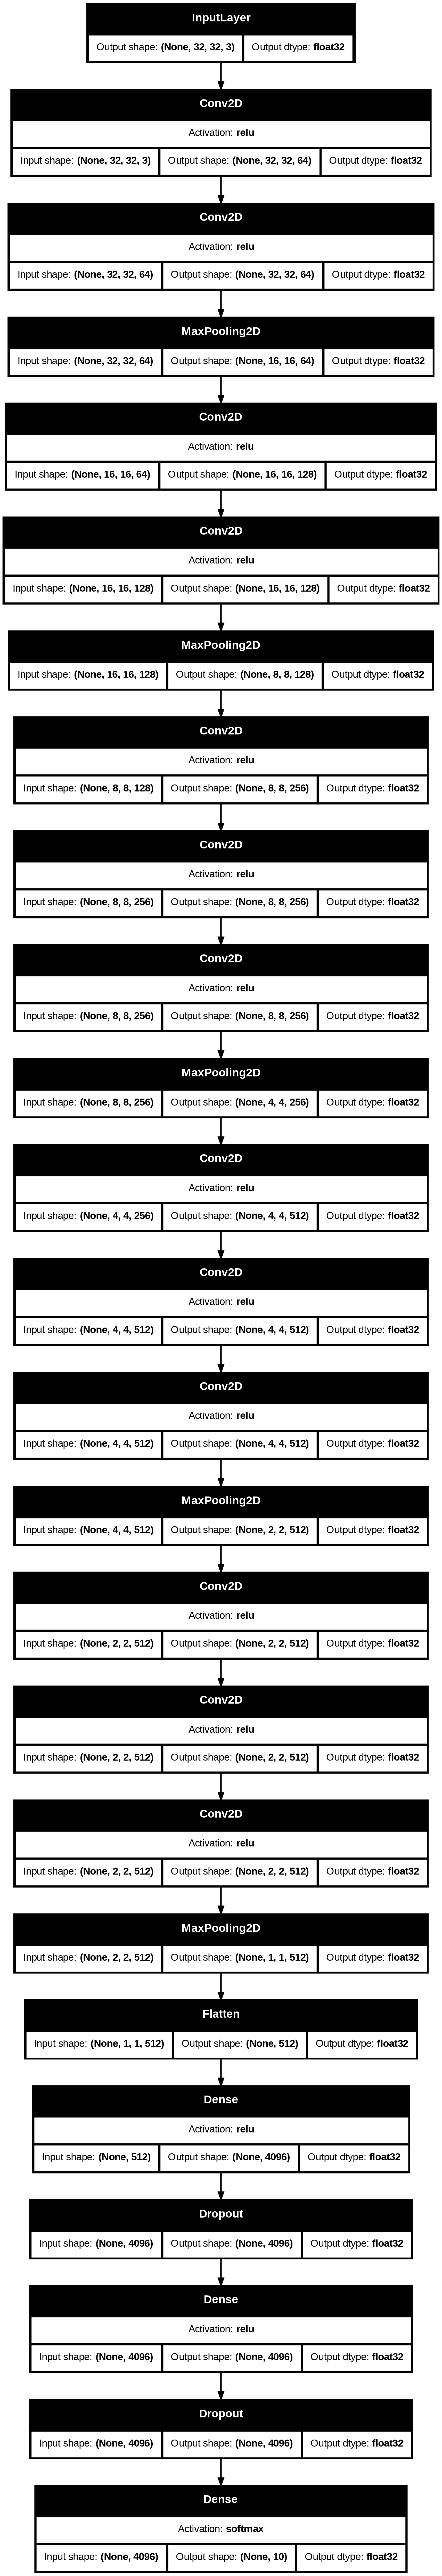

In [4]:
# Load pre-model
base_model = tf.keras.applications.vgg16.VGG16(input_shape = (32, 32, 3), include_top = False, weights = 'imagenet')
base_model.trainable=False
model=base_model.output

model=keras.layers.Flatten()(model)
model=keras.layers.Dense(4096, activation='relu')(model)
model=keras.layers.Dropout(rate=0.5)(model)
model=keras.layers.Dense(4096, activation='relu')(model)
model=keras.layers.Dropout(rate=0.5)(model)
model=keras.layers.Dense(10, activation='softmax')(model)
model=keras.models.Model(inputs=base_model.inputs, outputs=model)

# refer: https://keras.io/api/utils/model_plotting_utils/
keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_activations=True,
)

# custom Loss

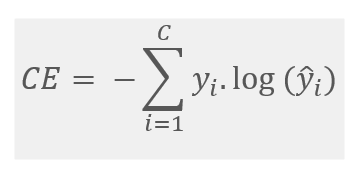

In [5]:
def customLossCategoricalCrossEntropy(y_true, y_predict):
  # log(e)(y_predict)
  log_y_predict = tf.math.log(y_predict)
  element_wise = -tf.math.multiply_no_nan(x=log_y_predict, y=y_true, name="AI")

  sum_element = tf.reduce_sum(element_wise, axis=1)
  mean_error = tf.reduce_mean(sum_element)

  return tf.cast(mean_error, dtype=tf.float64)

# check the Loss Function


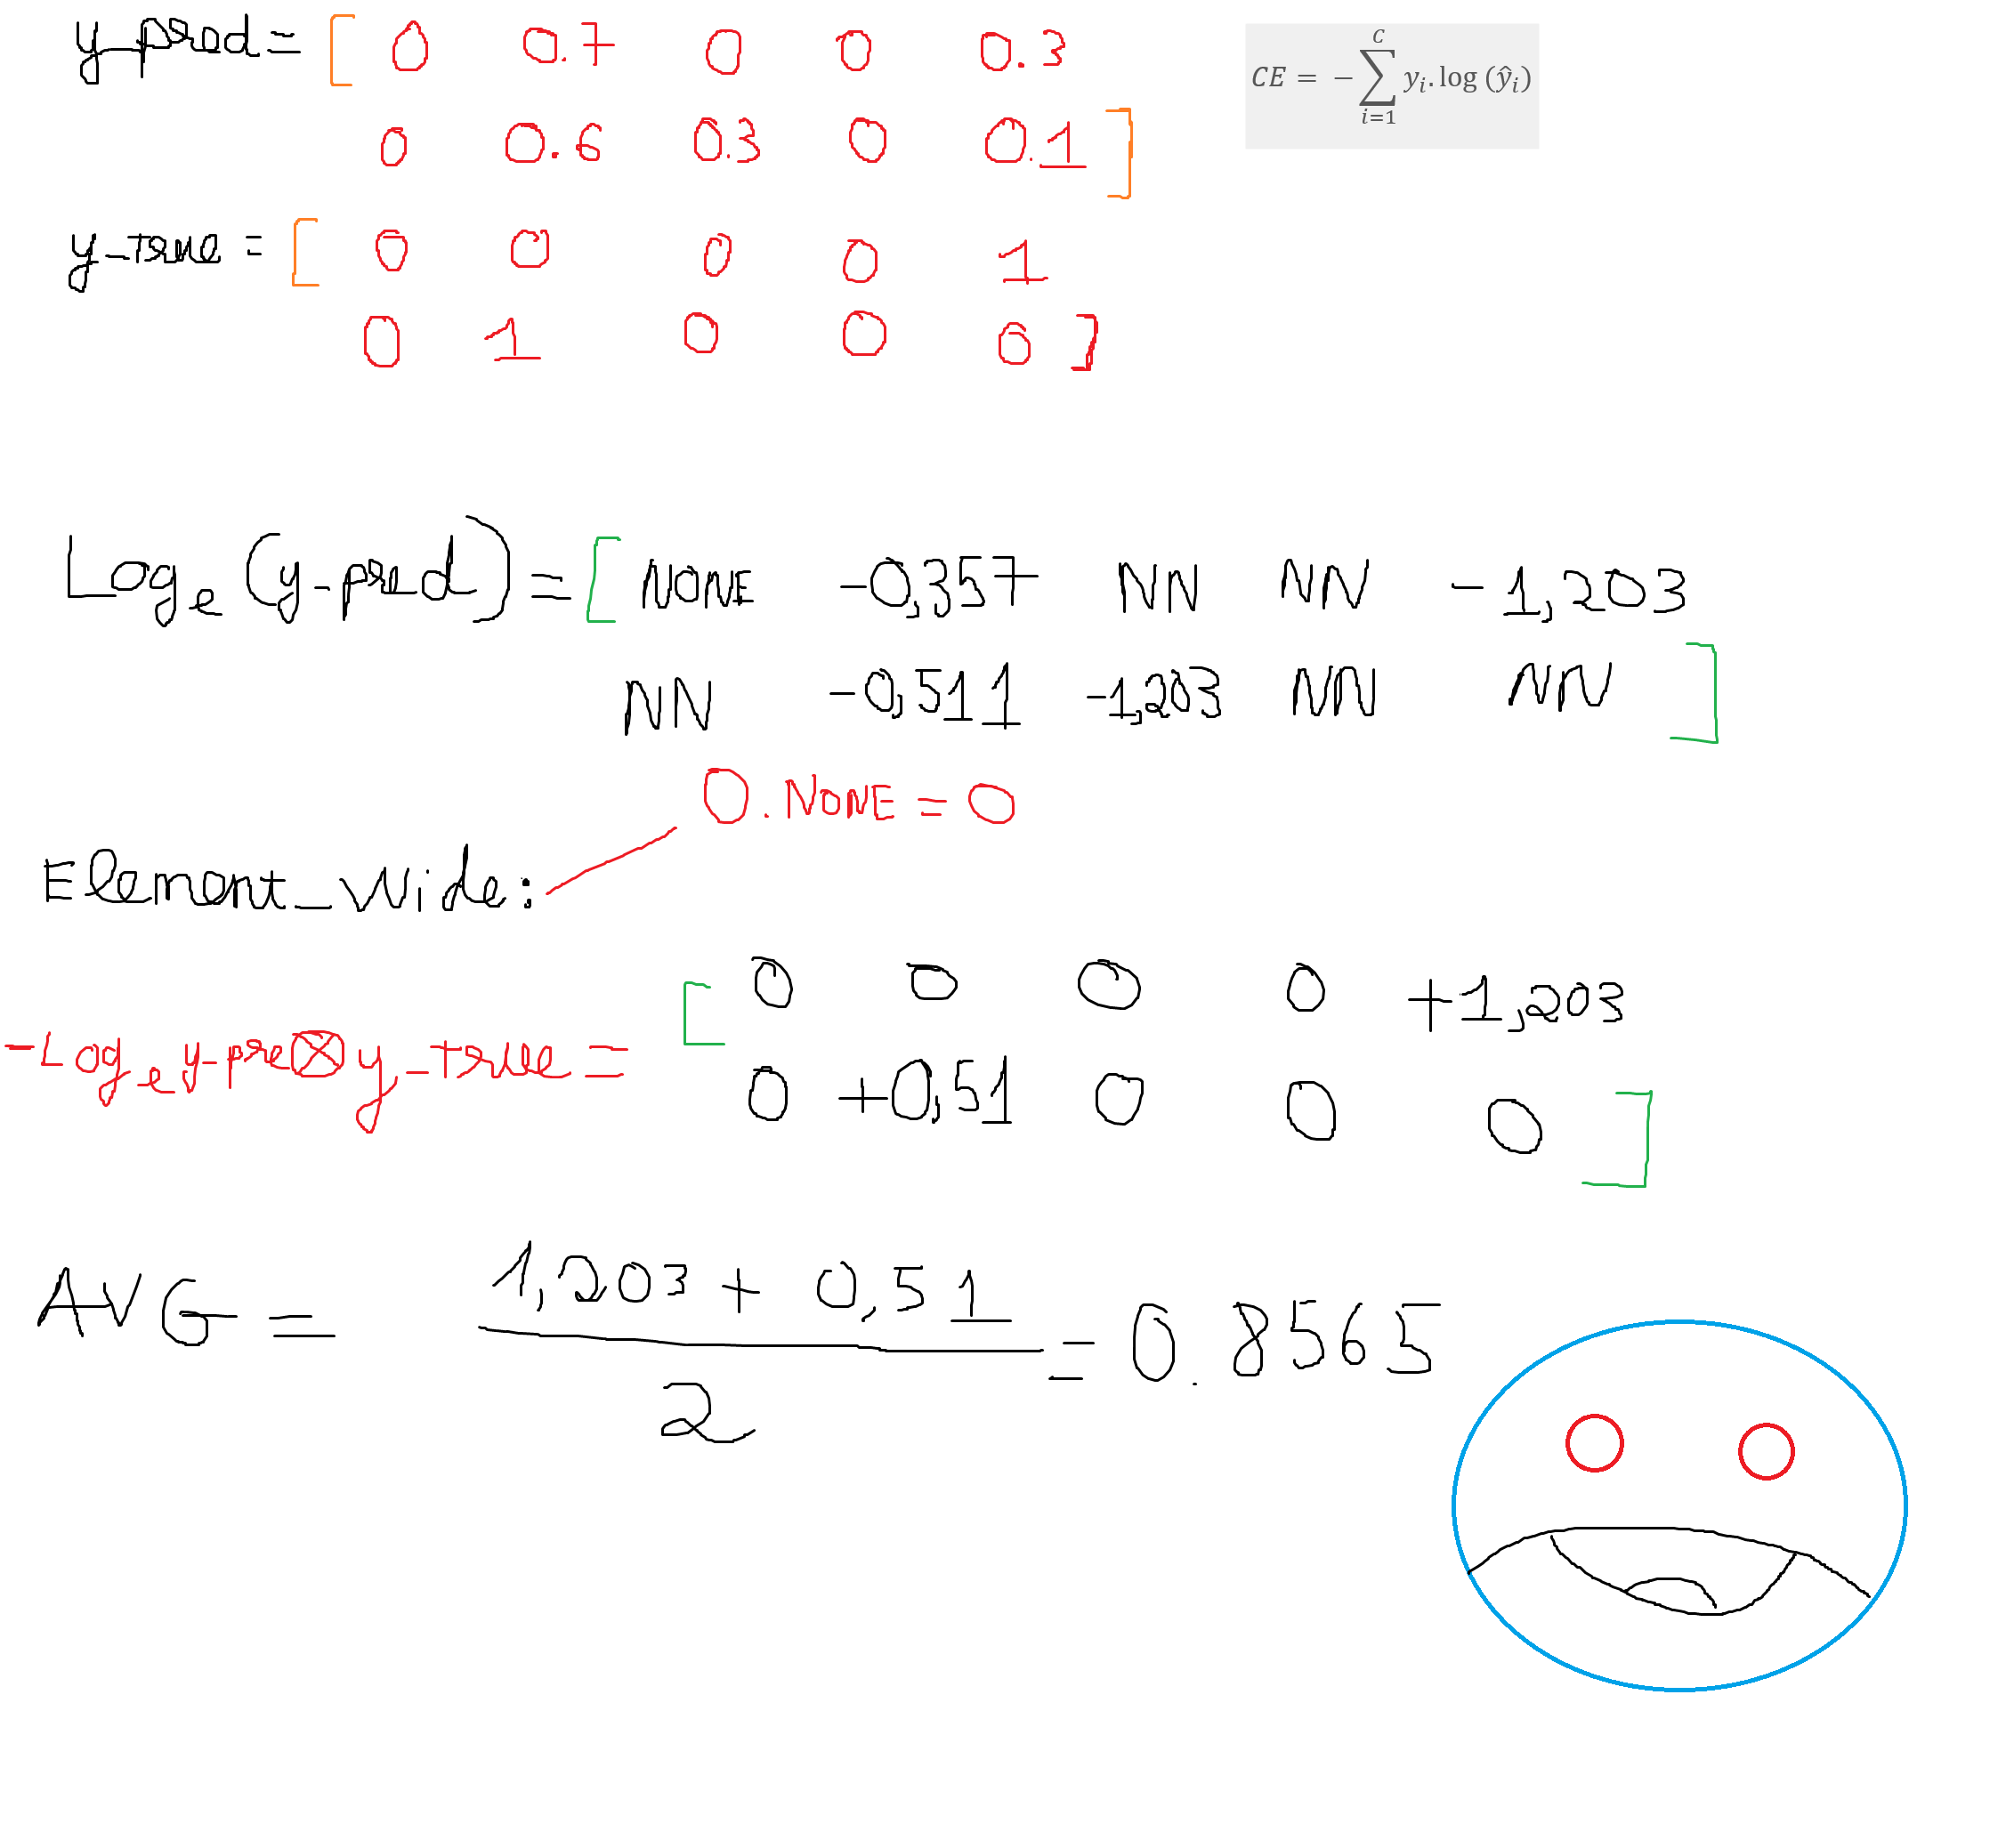

In [6]:
y_true = tf.constant(tf.keras.utils.to_categorical([4,1], num_classes=5)) # float64
y_predict = tf.constant(
    [[0.0 , 0.7 , 0.0 , 0.0,  0.3],
     [0.0 , 0.6 , 0.3  , 0.0, 0.1]]
    ) # float 32
y_predict = tf.cast(y_predict, dtype=tf.float64) # float64


Myloss = customLossCategoricalCrossEntropy(y_true, y_predict)

# get loss function crossentropy
Tensorflowloss = tf.keras.losses.CategoricalCrossentropy()

loss1 = Tensorflowloss(y_true, y_predict)


print("custom loss: ", Myloss.numpy())
print("tensorflow loss: ",loss1.numpy())
print("distans: ", Myloss.numpy() - loss1.numpy())

custom loss:  0.8573991743095342
tensorflow loss:  0.8573992
distans:  -5.092545118934311e-08


# fit model and evalute

In [21]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001,
)

model.compile(
    optimizer=optimizer,
    loss=customLossCategoricalCrossEntropy,
    metrics=["accuracy"]
)


history = model.fit(
    x=train_images,
    y=train_labels,
    epochs = 20,
    validation_data=(test_images, test_labels),
    verbose=1
)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.7097 - loss: 0.8270 - val_accuracy: 0.6388 - val_loss: 1.0618
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 12ms/step - accuracy: 0.7177 - loss: 0.7935 - val_accuracy: 0.6373 - val_loss: 1.0687
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.7315 - loss: 0.7586 - val_accuracy: 0.6382 - val_loss: 1.0752
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.7408 - loss: 0.7354 - val_accuracy: 0.6418 - val_loss: 1.0681
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.7441 - loss: 0.7195 - val_accuracy: 0.6437 - val_loss: 1.0982
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.7561 - loss: 0.6839 - val_accuracy: 0.6452 - val_loss: 1.0870
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.7632 - loss: 0.6649 - val_accuracy: 0.6410 - val_loss: 1.1064
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.7766 -

In [26]:
H = history.history

accuracy = H["accuracy"]
loss = H["loss"]
val_accuracy = H["val_accuracy"]
val_loss = H["val_loss"]

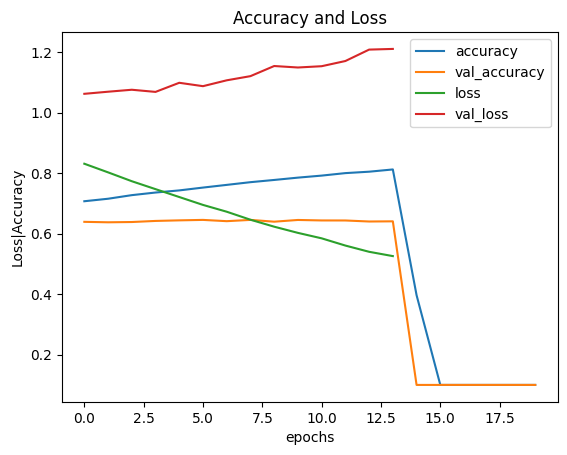

In [27]:
import matplotlib.pyplot as plt


fig = plt.figure()
numberOfEpoch = 20

plt.plot(np.arange(0,numberOfEpoch), accuracy, label="accuracy")
plt.plot(np.arange(0,numberOfEpoch), val_accuracy, label="val_accuracy")
plt.plot(np.arange(0,numberOfEpoch), loss, label="loss")
plt.plot(np.arange(0,numberOfEpoch), val_loss, label="val_loss")

plt.title("Accuracy and Loss")
plt.xlabel("epochs")
plt.ylabel("Loss|Accuracy")

plt.legend()

# evaluate

In [32]:
score = model.evaluate(test_images, test_labels, verbose=0)
loss = score[0]
accuracy = score[1]


print("Loss: ", loss)
print("accuracy: ", accuracy)

Loss:  nan
accuracy:  0.10000000149011612
